In [1]:
import pandas as pd

In [2]:
vanessa = r"C:\BigData\bbdc_2019_Bewegungsdaten_mit_referenz"

In [4]:
df_train=pd.read_csv(vanessa+'\\train.csv')

In [5]:
df_train

,Subject,Datafile,Label
0,Subject02,Subject02/Subject02_Aufnahme000.csv,curve-left-step
1,Subject02,Subject02/Subject02_Aufnahme001.csv,curve-left-step
2,Subject02,Subject02/Subject02_Aufnahme002.csv,stand-to-sit
3,Subject02,Subject02/Subject02_Aufnahme003.csv,curve-right-spin-Rfirst
4,Subject02,Subject02/Subject02_Aufnahme004.csv,jump-one-leg
...,...,...,...
6396,Subject19,Subject19/Subject19_Aufnahme435.csv,curve-left-spin-Rfirst
6397,Subject19,Subject19/Subject19_Aufnahme436.csv,jump-one-leg
6398,Subject19,Subject19/Subject19_Aufnahme437.csv,jump-two-leg
6399,Subject19,Subject19/Subject19_Aufnahme438.csv,curve-right-step


In [7]:
from sklearn.decomposition import PCA
labels=list(df_train.Label.unique())
#labels='stand-to-sit'
models=[]

for each in labels:
    print(each)
    pca = PCA (n_components =275)
    df=df_train[df_train['Label']==each]
    files=list(df.Datafile)
    arr={}
    col_sub='EMG1,EMG2,EMG3,EMG4,Airborne,ACC_upper_X,ACC_upper_Y,ACC_upper_Z,Goniometer_X,\
    ACC_lower_X,ACC_lower_Y,ACC_loewr_Z,Goniometer_Y,Gyro_upper_X,Gyro_upper_Y,Gyro_upper_Z,\
    Gyro_lower_X,Gyro_lower_Y,Gyro_lower_Z'
    j=0
    for each_file in files:
        #print(each_file)
        df_explo=pd.read_csv(vanessa+'\\Subjects\\'+each_file.replace('/','\\'),names=col_sub.split(','))
        #print(each_file,each)
        try:
            x=list(df_explo.values[10:3000].reshape((1, 56810))[0]) 
        except:
            #complete by repetition
            df_temp=df_explo.append(df_explo).append(df_explo).append(df_explo)
            x=list(df_temp.values[10:3000].reshape((1, 56810))[0])
        arr[j]=x
        j=j+1
    for_pca=pd.DataFrame.from_dict(arr, orient='index')
    
    print(each,'number of rows',j)
    if(each=='lay'):
        pca = PCA (n_components =16)
        
    models.append(pca.fit(for_pca))

curve-left-step
curve-left-step number of rows 299
stand-to-sit
stand-to-sit number of rows 289
curve-right-spin-Rfirst
curve-right-spin-Rfirst number of rows 300
jump-one-leg
jump-one-leg number of rows 279
lateral-shuffle-right
lateral-shuffle-right number of rows 277
curve-right-spin-Lfirst
curve-right-spin-Lfirst number of rows 301
v-cut-right-Lfirst
v-cut-right-Lfirst number of rows 300
stair-down
stair-down number of rows 278
v-cut-left-Rfirst
v-cut-left-Rfirst number of rows 280
v-cut-right-Rfirst
v-cut-right-Rfirst number of rows 280
jump-two-leg
jump-two-leg number of rows 280
sit
sit number of rows 289
stair-up
stair-up number of rows 278
curve-right-step
curve-right-step number of rows 295
sit-to-stand
sit-to-stand number of rows 289
run
run number of rows 300
v-cut-left-Lfirst
v-cut-left-Lfirst number of rows 300
stand
stand number of rows 289
curve-left-spin-Lfirst
curve-left-spin-Lfirst number of rows 280
walk
walk number of rows 300
curve-left-spin-Rfirst
curve-left-spin

In [11]:
#From saving the object models as a file for later usage
import pickle
with open("models_pca.file", "wb") as f:
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

In [12]:
import pickle
#calling from hard drive
with open("models_pca.file", "rb") as f:
    models_pca = pickle.load(f)
    # Now you can use the dump object as the original one  
    #self.some_property = dump.some_property

In [14]:
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import make_scorer

df_train=pd.read_csv(vanessa+'\\train.csv')
import numpy as np
#Data_PCA=model[0].transform(Data)


labels=list(pd.read_csv(vanessa+'\\train.csv').Label.unique())

index_label=0

#here we our 22 models.
list_models=[]

for each in labels:
    df_train=pd.read_csv(vanessa+'\\train.csv')
    #df=df_train[df_train['Label']==each]
    df_train['Label'] = df_train['Label'].apply(lambda x: 1 if x==each else 0)
    l_df=list(df_train.values)
    files=list(df_train.Datafile)
    arr_trans={}
    col_sub='EMG1,EMG2,EMG3,EMG4,Airborne,ACC_upper_X,ACC_upper_Y,ACC_upper_Z,Goniometer_X,ACC_lower_X,ACC_lower_Y,ACC_loewr_Z,Goniometer_Y,Gyro_upper_X,Gyro_upper_Y,Gyro_upper_Z,Gyro_lower_X,Gyro_lower_Y,Gyro_lower_Z'
    j=0
    dict_val_X,dict_val_y={},{}
    for each_file in files:
        #print(each_file)
        df_explo=pd.read_csv(vanessa+'\\Subjects\\'+each_file.replace('/','\\'),names=col_sub.split(','))
        #print(each_file,each)
        try:
            x=np.array(df_explo.values[10:3000].reshape((1, 56810))[0]) 
        except:
            #complete by repetition
            df_temp=df_explo.append(df_explo).append(df_explo).append(df_explo)
            x=np.array(df_temp.values[10:3000].reshape((1, 56810))[0])
        dict_val_X[j]=models_pca[index_label].transform(x.reshape(1, -1))[0]
        dict_val_y[j]=l_df[j][2]
        j=j+1
        
    X=np.array(list(dict_val_X.values()))
    y=np.array(list(dict_val_y.values()))
    f1_score_weighted = make_scorer(f1_score, average='weighted')
    CV_LR = LogisticRegressionCV(cv=10,  Cs=[0.1,0.5, 1,1.5, 5,10,50, 100],scoring=f1_score_weighted)
    #Este el objeto que nos interesa, este el modelo entranado.
    cv_classifier_LR= CV_LR.fit(X, y)
    list_models.append(cv_classifier_LR)
    print('classifier for ',each, ' ready. X_shape:', X.shape)
    index_label += 1

classifier for  curve-left-step  ready. X_shape: (6401, 275)
classifier for  stand-to-sit  ready. X_shape: (6401, 275)
classifier for  curve-right-spin-Rfirst  ready. X_shape: (6401, 275)
classifier for  jump-one-leg  ready. X_shape: (6401, 275)
classifier for  lateral-shuffle-right  ready. X_shape: (6401, 275)
classifier for  curve-right-spin-Lfirst  ready. X_shape: (6401, 275)
classifier for  v-cut-right-Lfirst  ready. X_shape: (6401, 275)
classifier for  stair-down  ready. X_shape: (6401, 275)
classifier for  v-cut-left-Rfirst  ready. X_shape: (6401, 275)
classifier for  v-cut-right-Rfirst  ready. X_shape: (6401, 275)
classifier for  jump-two-leg  ready. X_shape: (6401, 275)
classifier for  sit  ready. X_shape: (6401, 275)
classifier for  stair-up  ready. X_shape: (6401, 275)
classifier for  curve-right-step  ready. X_shape: (6401, 275)
classifier for  sit-to-stand  ready. X_shape: (6401, 275)
classifier for  run  ready. X_shape: (6401, 275)
classifier for  v-cut-left-Lfirst  ready.

In [15]:
#From saving the object models as a file for later usage
import pickle
with open("list_models.file", "wb") as f:
    pickle.dump(list_models, f, pickle.HIGHEST_PROTOCOL)

In [16]:
import pickle
with open("list_models.file", "rb") as f:
    list_models = pickle.load(f)

In [17]:
import numpy as np
import operator

labels=list(pd.read_csv(vanessa+'\\train.csv').Label.unique())

real_pred=[]
df_test=pd.read_csv(vanessa+'\\train.csv')
files=list(df_test.Datafile)
arr={}
#ln_labels=list(df_test.Label)
for each_data in files:
    df_explo=pd.read_csv(vanessa+'\\Subjects\\'+each_data.replace('/','\\'))
    try:
        x=np.array(df_explo.values[10:3000].reshape((1, 56810))[0]) 
    except:
        #complete by repetition
        df_temp=df_explo.append(df_explo).append(df_explo).append(df_explo)
        x=np.array(df_temp.values[10:3000].reshape((1, 56810))[0])
    
    index_label=0
    arr={}
    for each_label in labels:
        predi=models_pca[index_label].transform(x.reshape(1, -1))[0]
        XX=list_models[index_label].predict_proba(predi.reshape(1, -1))
        arr[index_label]=[XX[0][0]]
        #larr[index_label]=[ln_labels[index_label]]
        index_label += 1
    #here we select the maximum probality of the array of class predictions probalities
    
    real_pred.append(arr)
    
    #real_pred.append(labels[max(arr.items(), key=operator.itemgetter(1))[0]])

In [18]:
X_train_dic={}
y_train_dic={}

In [19]:
X_train_dic['Label_predicted_array']=real_pred

fuck={}
nn=0
al=[]
for each in real_pred:
    #print(list(each.values()))
    #nn=0
    for cada in list(each.values()):
        al.append(cada[0])
    fuck[nn]=al
    nn=nn+1
    al=[]
    
#data=np.array(fuck)
df = pd.DataFrame(fuck)  
#fuck
#fuck[1]
r_df=df.T
r_df.columns=labels

classes=list(df_test.Label.values)
y_train_dic['Target']=classes
#dicrr['real']=real_pred
#X_train_dic['Label_predicted_array']=real_pred
#Subject,Datafile,Label

data_X_train=r_df
data_y_train=pd.DataFrame.from_dict(y_train_dic)

In [20]:
from sklearn.model_selection import train_test_split


#From saving the object models as a file for later usage
import pickle
with open("data_X_train.file", "wb") as f:
    pickle.dump(data_X_train, f, pickle.HIGHEST_PROTOCOL)
    
with open("data_y_train.file", "wb") as f:
    pickle.dump(data_y_train, f, pickle.HIGHEST_PROTOCOL)

    
with open("data_X_train.file", "rb") as f:
    data_X_train = pickle.load(f)
    # Now you can use the dump object as the original one  
    #self.some_property = dump.some_property

with open("data_y_train.file", "rb") as f:
    data_y_train = pickle.load(f)
    # Now you can use the dump object as the original one  
    #self.some_property = dump.some_property
    
#random_state is the seed of the random selection, use the same to ensure reproducibility.
X_train,X_test,y_train,y_test = train_test_split(data_X_train,data_y_train,test_size=0.25,random_state=0)

In [21]:
from sklearn import tree

#Create the object model.
tree_model = tree.DecisionTreeClassifier()
#Fit the model.
tree_model = tree_model.fit(X_train, y_train)

In [22]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#Here create the martrix of prediction over the test sets.
y_pred_test=tree_model.predict(X_test)

#Here create the martrix of prediction over the train sets.
y_pred_train=tree_model.predict(X_train)



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_test)
np.set_printoptions(precision=2)

In [23]:
def accuracy(confusion_matrix):
    sum_diagonal=sum(np.diagonal(confusion_matrix))
    total=sum(sum(confusion_matrix))
    return (sum_diagonal/total)

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

In [24]:
print("Overall TEST accuracy")
print("----->",accuracy(cnf_matrix))
print("------------------------------------------------")

print("Overall TRAIN accuracy")
print("----->",accuracy(confusion_matrix(y_train, y_pred_train)))
print("------------------------------------------------")

Overall TEST accuracy
-----> 0.7589006870705809
------------------------------------------------
Overall TRAIN accuracy
-----> 1.0
------------------------------------------------


In [28]:
import seaborn as sn
import matplotlib.pyplot as plt

[Text(0, 0.5, 'curve-left-step'),
 Text(0, 2.5, 'stand-to-sit'),
 Text(0, 4.5, 'curve-right-spin-Rfirst'),
 Text(0, 6.5, 'jump-one-leg'),
 Text(0, 8.5, 'lateral-shuffle-right'),
 Text(0, 10.5, 'curve-right-spin-Lfirst'),
 Text(0, 12.5, 'v-cut-right-Lfirst'),
 Text(0, 14.5, 'stair-down'),
 Text(0, 16.5, 'v-cut-left-Rfirst'),
 Text(0, 18.5, 'v-cut-right-Rfirst'),
 Text(0, 20.5, 'jump-two-leg'),
 Text(0, 22.5, 'sit')]

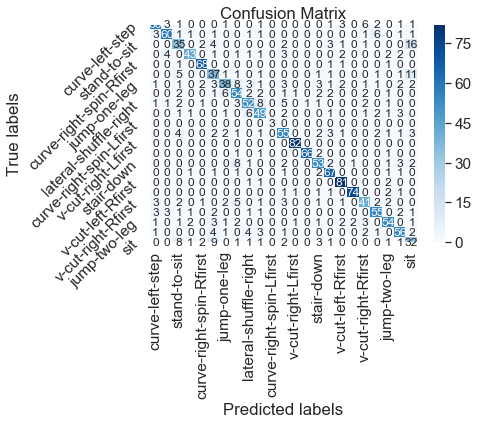

In [73]:
ax= plt.subplot(111)
sn.set(font_scale=1.4)
sn.heatmap(cnf_matrix, annot=True, cmap = "Blues", annot_kws={"size": 12}, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels, rotation=90) 
ax.yaxis.set_ticklabels(labels, rotation=45)

<Figure size 432x288 with 0 Axes>

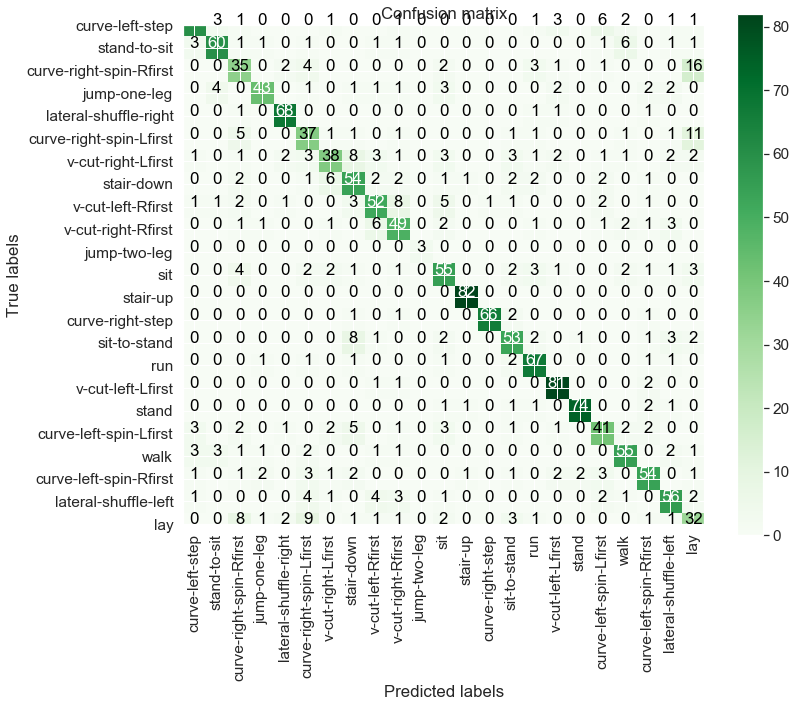

In [81]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='Greens'):

    
    size = (12, 10)
    fig, ax = plt.subplots(figsize=size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()

# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,title='Confusion matrix')